### Prisma Data Analysis

Table of contents: 

  1. Importing librairies
  2. Defining functions
  3. Collecting data from file
  4. Plotting RGB
  5. Creating Pandas Geodataframe
  6. Importing Tare data


**1. Importing librairies**

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.ops import unary_union
from shapely.geometry import box

**2. Defining functions**

In [39]:
def normalise(pic):
    '''
    Input:
    pic: array of values we want to normalise
    
    Output: 
    new: normalised array
    '''
    max = pic.max()
    min = pic.min()
    new = (pic - min)/(max-min)
    return new

def create_geopandas(data):
    '''
    Input:
    data: Pandas with corrected bands and lat and lon coord per row

    Output:
    Geodataframe, where each row represents a pixel. band values and geometry.
    '''
    df_all = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.lon, data.lat))
    df_all["label"] = np.zeros(len(data))
    return df_all

def label(number_of_slices, df_all, seaweed_mask): 
    '''
    Input: 
        number_of_slices: How many slices do we want. 
        df_all: Band data from prisma 
        seaweed_mask: Naturdirektoratet data

    Output:

    None 

    '''
    lon_min, lat_min, lon_max, lat_max = df_all.total_bounds
    dlon = (lon_max-lon_min)/number_of_slices
    dlat = (lat_max-lat_min)/number_of_slices
    
    count = 0 
    print("count will go up to " + str(number_of_slices**2))
    for i in range(number_of_slices-1):
        lat_lower = lat_min + i*dlat
        lat_upper = lat_min + (i+1)*dlat
        for j in range(number_of_slices-1):
            lon_left = lon_min + j*dlon
            lon_right = lon_min + (j+1)*dlon
            seaweed_current = gpd.clip(seaweed_mask, box(*(lon_left, lat_lower, lon_right, lat_upper)))
            print(count)
            count+=1
            if not seaweed_current.empty:
                polygons = unary_union(seaweed_current.geometry)
                df_all_current = gpd.clip(df_all, box(*(lon_left, lat_lower, lon_right, lat_upper)))
                df_all.loc[df_all_current.index, "label"] = df_all_current.geometry.within(polygons).astype(int)


**3. Collecting data from file**

In [40]:
filename = "..\data\df_for_malan3.pickle"
data = pd.read_pickle(filename)

**4. Importing Tare data**

In [5]:
#Denne cellen tar 1 min 25 sek
data_naturdirektoratet = gpd.read_file("../data/naturdirektoratet.json")
seaweed = data_naturdirektoratet.copy()
seaweed= seaweed.loc[seaweed["naturtype"] == "størreTareskogforekomster"]

**5. Creating Geopandas**

In [41]:
#Denne tar 45 sekund å kjøre
df_all = create_geopandas(data)

**6. Preparing data from Naturdirektoratet** 

<AxesSubplot:>

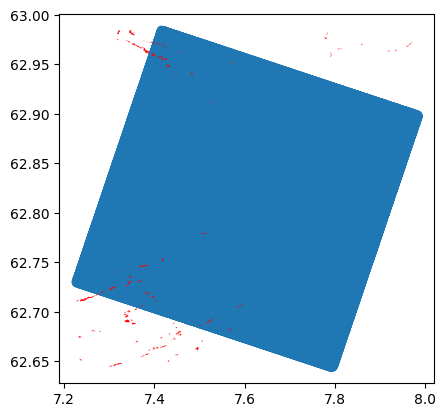

In [42]:
seaweed_mask= gpd.clip(seaweed, box(*df_all.total_bounds))
ax = df_all.plot()
seaweed_mask.plot(ax = ax, color = "red")

**7. Labelling the data**

In [43]:
#Denne tar sånn 10 min å kjøre
number_of_slice = 10
label(number_of_slice, df_all, seaweed)

count will go up to 100
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


**8.Checking wether everything is correct**

Text(88.36066711210601, 0.5, 'lat')

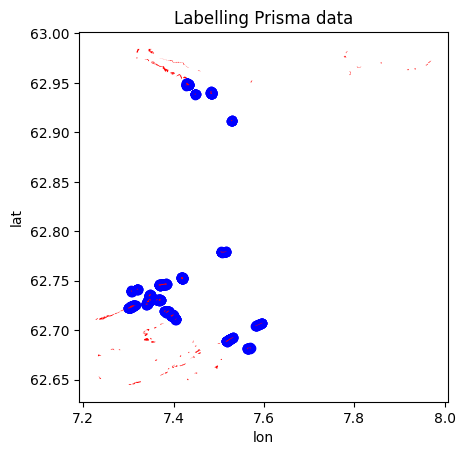

In [44]:
df_all_true = df_all[df_all["label"] == True].copy()
fig, ax = plt.subplots()
df_all_true.plot(ax = ax, color = "blue")
seaweed_mask.plot(ax = ax, color = "red")
ax.set_title("Labelling Prisma data")
ax.set_xlabel("lon")
ax.set_ylabel("lat")


**9.Creating csv files**

In [45]:
df_all.to_csv("..\data\df_all.csv")